In [1]:
cd ..

C:\Users\Sommer Lab\Documents\Analysis Code


In [2]:
from ImageAnalysis import ImageAnalysisCode
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import pandas as pd
import os

In [23]:
####################################
#Set the date and the folder name
####################################
dataRootFolder =r"D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data"
date = '5/21/2024'

ODT_Position = '1900'
task = 'Misalign'
task = 'Align'
expectedValues = [878.966, 1918.697]

data_folder = ' '.join([r'Andor/ODT',  ODT_Position, task])
Basler_folder = ' '.join([r'Basler/ODT',  ODT_Position, task])

####################################
#Parameter Setting
####################################
repetition = 3 #The number of identical runs to be averaged.
subtract_burntin = 0
examNum = 5 #The number of runs to exam.
examFrom = None #Set to None if you want to check the last several runs. 
plotPWindow = 3
intermediatePlot = True
uniformscale = 0
rcParams = {'font.size': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9}

variablesToDisplay = [
                    # 'Coil_medB', 
                       'ODT Misalign', 
                       'ODT Position',
                      'ZSBiasCurrent',
                      'VerticalBiasCurrent',
                       'CamBiasCurrent'
                      ]
showTimestamp = False
# variablesToDisplay=None
textY = 1
textVA = 'bottom'

variableFilterList = None
variableFilterList = [
    # 'wait==50', 
    ] # NO SPACE around the operator!

pictureToHide = None
# pictureToHide = [0,1,2,3] # list(range(0,10,2))

subtract_bg = 0
signal_feature = 'narrow' 
signal_width = 10 #The narrower the signal, the bigger the number.
fitbgDeg = 5
rotateAngle= 0.56 #rotates ccw

rowstart = 10
rowend = -10
columnstart = 10
columnend = -10

# columnstart = 500
# columnend = 1400

# rowstart =750 #ODT 2675
# rowend = 830
# rowstart =616 #ODT1675
# rowend = 651
rowstart =570 #ODT1900
rowend = 670
# # rowstart = 800 #ODT990
# # rowend = 835

# rowstart = 888 #ODT700
# rowend = 923
# rowstart = 1032 #ODT400
# rowend = 1068

# rowstart = 543 #ODT3400
# rowend = 578

rowstart -= 180
rowend += 150

####################################
####################################
dayfolder = ImageAnalysisCode.GetDataLocation(date, DataPath=dataRootFolder)
dataPath = os.path.join(dayfolder, data_folder)
# variableLog_folder = os.path.join(dayfolder, 'Variable Logs')
examFrom, examUntil = ImageAnalysisCode.GetExamRange(examNum, examFrom, repetition)

pPI = 4 if subtract_burntin else 3
params = ImageAnalysisCode.ExperimentParams(date, t_exp = 10e-6, picturesPerIteration=pPI, cam_type = "zyla")

subtract burntin	 0
picture/iteration	 4
skip firstImg		 1
first frame			 1
Loading pictures: ||
Finish loading pictures, 60 raw images loaded.


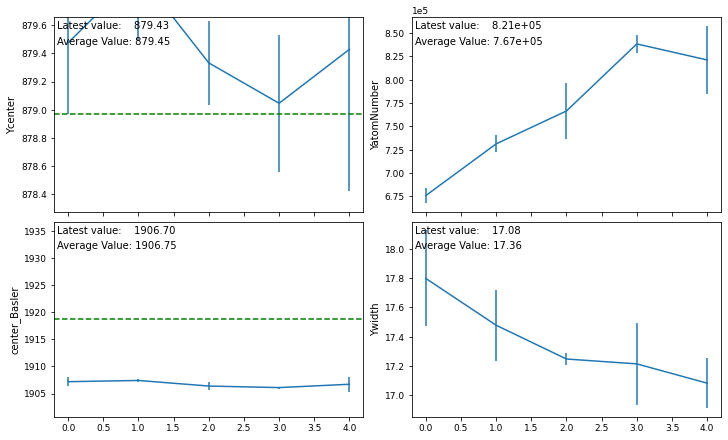

In [72]:


columnDensities, variableLog = ImageAnalysisCode.PreprocessZylaImg(dataPath, examRange=[examFrom, examUntil], 
                                                                   rowstart=rowstart, rowend=rowend, 
                                                                   columnstart=columnstart, columnend=columnend,
                                                                   rotateAngle=rotateAngle, subtract_burntin=0)
# %%

dx = params.camera.pixelsize_microns/params.magnification #The length in micron that 1 pixel correspond to. 
YcolumnDensities = columnDensities.sum(axis=2) * dx / 1e6**2

popts = []
bgs = []
for ydata in YcolumnDensities:
    popt, _, bg = ImageAnalysisCode.fitMultiGaussian(ydata, dx=dx, 
                                                  subtract_bg=subtract_bg, signal_feature=signal_feature, 
                                                  fitbgDeg=3, amp=1, width=3, denoise=0)
    popts.append(popt)
    bgs.append(bg)
    
# XcolumnDensities = columnDensities.sum(axis=1) * dx / 1e6**2
# poptsX = []
# for xdata in XcolumnDensities:
#     poptx,_ = ImageAnalysisCode.fitSingleGaussian(xdata, dx=dx,
#                                                   subtract_bg=1, signal_feature='wide')
#     poptsX.append(poptx)

results = ImageAnalysisCode.AnalyseFittingResults([popts], logTime=variableLog.index)

if variableLog is not None:
    results = results.join(variableLog)
# results.to_csv('0305.csv')

# %%
# Load the Basler pictures
data_folder_Basler = os.path.join(dayfolder, Basler_folder)
files = os.listdir(data_folder_Basler)
files.sort()
fileNo = len(files)

imgs_Basler = []
for file in files[examFrom: examUntil]:
    path = os.path.join(data_folder_Basler, file)
    imgs_Basler.append( plt.imread(path)[...,0] )
imgs_Basler = np.array(imgs_Basler)

# Fit 1-D picture
imgs_oneD = imgs_Basler.sum(axis=1)
popt_Basler=[]
for ii in imgs_oneD:
    popt, _ = ImageAnalysisCode.fitSingleGaussian(ii, signal_feature='narrow')
    popt_Basler.append(popt)

# Extract the position of the light and conbime it with the data from Zyla
center_Basler = [ii[1] for ii in popt_Basler]
dfjoin = results[['ODT_Misalign', 'Ycenter', 'Ywidth', 'YatomNumber']].copy()
dfjoin['center_Basler'] = center_Basler

if task.startswith('Align'):
    ImageAnalysisCode.odtAlign(dfjoin, *expectedValues, repetition=repetition,
                               rcParams=rcParams)
    
elif task.startswith('Misalign'):
    ImageAnalysisCode.odtMisalign(dfjoin, rcParams=rcParams)


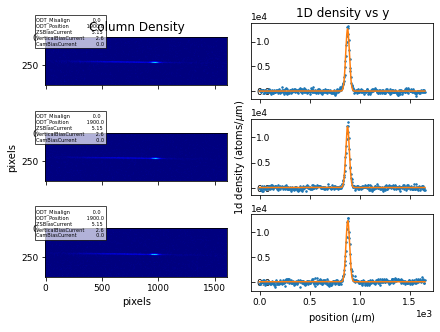

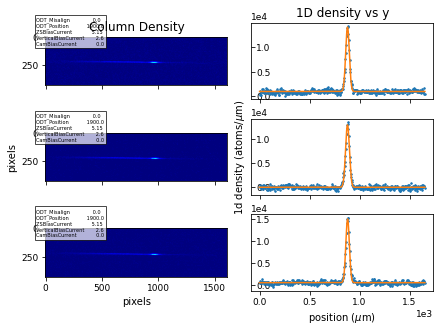

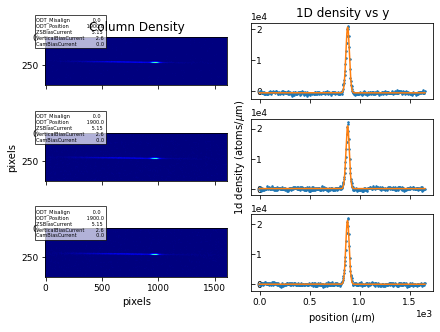

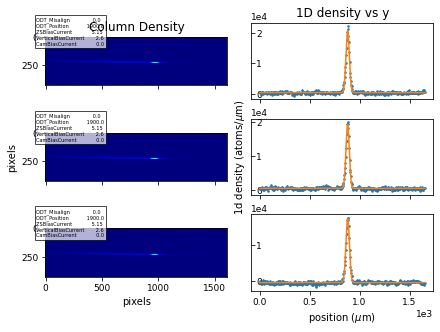

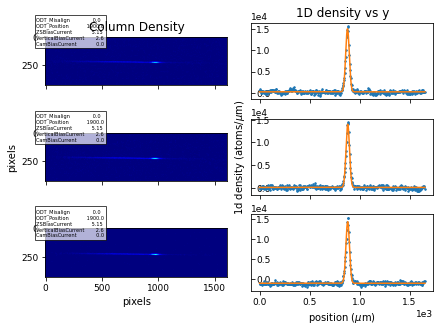

In [62]:
ImageAnalysisCode.plotImgAndFitResult(columnDensities, [popts], bgs=bgs, dx=dx, 
                                          plotPWindow=plotPWindow,
                                          variablesToDisplay = variablesToDisplay,
                                          variableLog=variableLog, logTime=variableLog.index,
                                          textLocationY=0.8, rcParams=rcParams)

In [41]:
f = r'D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data\2024\03-2024\09 Mar 2024\Basler\ODT 3400 Realign'

In [70]:
# %%
# Load the Basler pictures
# data_folder_Basler = os.path.join(dataLocation, Basler_folder)
files = os.listdir(f)
files.sort()
fileNo = len(files)

imgs_Basler = []
for file in files[examFrom:examUntil]:
    path = os.path.join(f, file)
    imgs_Basler.append( plt.imread(path)[...,0] )
imgs_Basler = np.array(imgs_Basler)

# Fit 1-D picture
imgs_oneD = imgs_Basler.sum(axis=1)
popt_Basler=[]
for ii in imgs_oneD:
    popt, _ = ImageAnalysisCode.fitSingleGaussian(ii, signal_feature='narrow')
    popt_Basler.append(popt)

# Extract the position of the light and conbime it with the data from Zyla
center_Basler = [ii[1] for ii in popt_Basler]


df = pd.DataFrame({'center_Basler': center_Basler})
dfMean = df.groupby(df.index//3).mean()
dfStd = df.groupby(df.index//3).std()

Text(0.01, 0.98, 'Latest value: 3404.51')

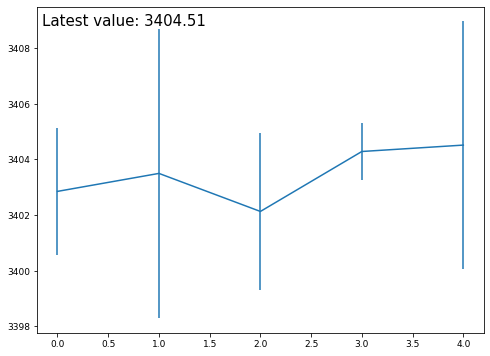

In [71]:
fig, ax = plt.subplots(1,1,figsize=[8,6])
ax.errorbar(dfMean.index, dfMean.center_Basler, dfStd.center_Basler*5, )
ax.text(0.01, 0.98, 'Latest value: {:.2f}'.format(dfMean.center_Basler.iloc[-1]), fontsize=15, va='top', transform=ax.transAxes)